# Analysis of the use of rented bicycles in Seoul (South Korea)

## Importation of the main libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style="darkgrid")

## Importing the dataset

Data obtained in <https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand>

In [73]:
dataset = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', 
    encoding='ISO-8859-1')

## Outlier detection

In [71]:
## thanks to https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR                
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

Outliers_to_drop = detect_outliers(dataset,1,
      ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'])

dataset.loc[Outliers_to_drop] # Show the outliers rows

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
4072,19/05/2018,2479,16,24.5,34,1.5,2000,7.5,2.54,0.0,0.0,Spring,No Holiday,Yes
5155,03/07/2018,2598,19,30.4,62,0.9,2000,22.2,0.65,0.1,0.0,Summer,No Holiday,Yes
231,10/12/2017,180,15,6.7,63,4.5,715,0.1,0.35,0.0,1.0,Winter,No Holiday,Yes
732,31/12/2017,209,12,1.4,47,4.5,1388,-8.7,1.10,0.0,1.0,Winter,Holiday,Yes
933,08/01/2018,146,21,0.7,77,6.7,692,-2.8,0.00,0.9,1.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,03/02/2018,60,3,-4.4,80,4.3,346,-7.3,0.00,0.1,0.1,Winter,No Holiday,Yes
2016,23/02/2018,42,0,1.7,86,2.7,54,-0.3,0.00,0.4,0.4,Winter,No Holiday,Yes
2019,23/02/2018,32,3,0.9,97,1.2,243,0.4,0.00,3.7,4.1,Winter,No Holiday,Yes
8601,24/11/2018,24,9,0.3,97,3.0,34,-0.1,0.00,9.1,7.1,Autumn,No Holiday,Yes


In [ ]:
dtWitOut = dataset.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Exploratory analysis

### Are there null values?

In [70]:
pd.isnull(dtWitOut.columns)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

### Histograns for each numerical attribute

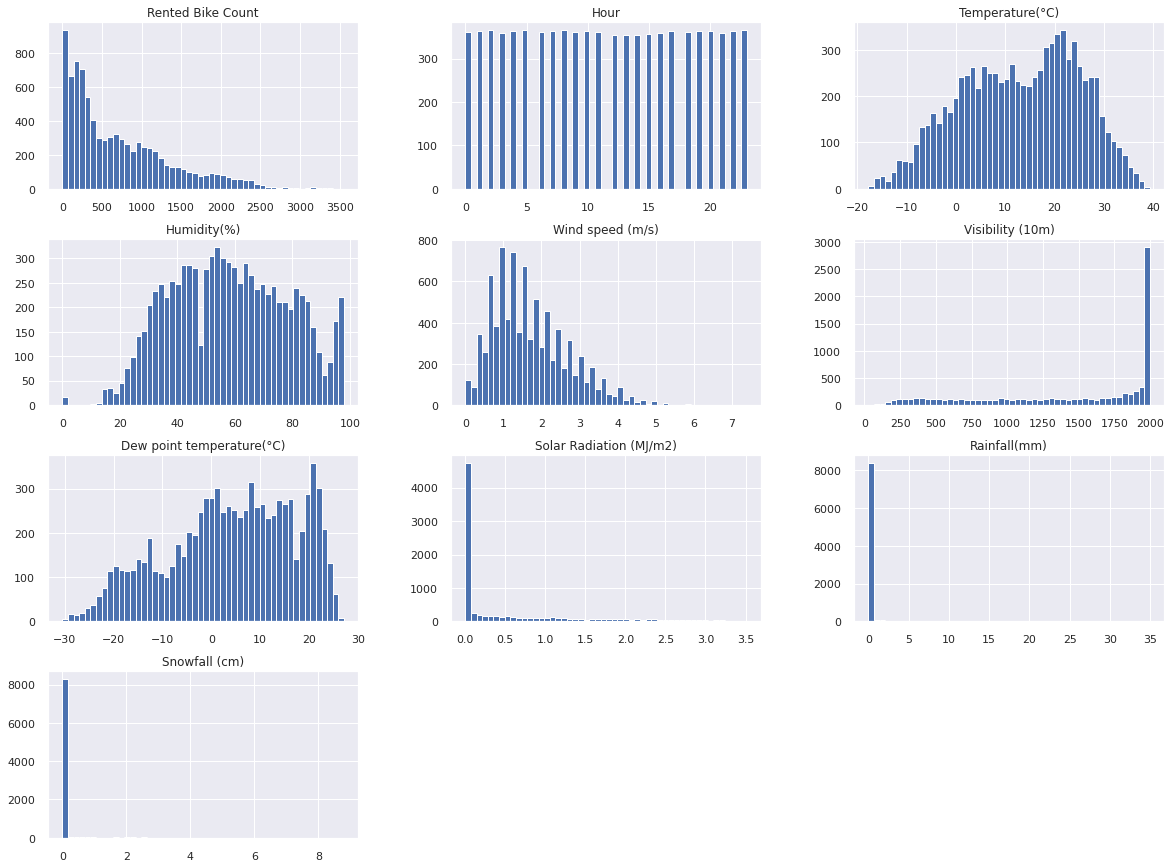

In [ ]:
dtWitOut.hist(bins=50, figsize=(20,15))
plt.show()

### Detecting Correlations

In [ ]:
corr_matrix = dtWitOut.corr()
corr_matrix["Rented Bike Count"].sort_values(ascending=False)

Rented Bike Count            1.000000
Temperature(°C)              0.537387
Hour                         0.412104
Dew point temperature(°C)    0.379811
Solar Radiation (MJ/m2)      0.260780
Visibility (10m)             0.194915
Wind speed (m/s)             0.132113
Rainfall(mm)                -0.120186
Snowfall (cm)               -0.135997
Humidity(%)                 -0.196075
Name: Rented Bike Count, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66b8176be0>,
      dtype=object)

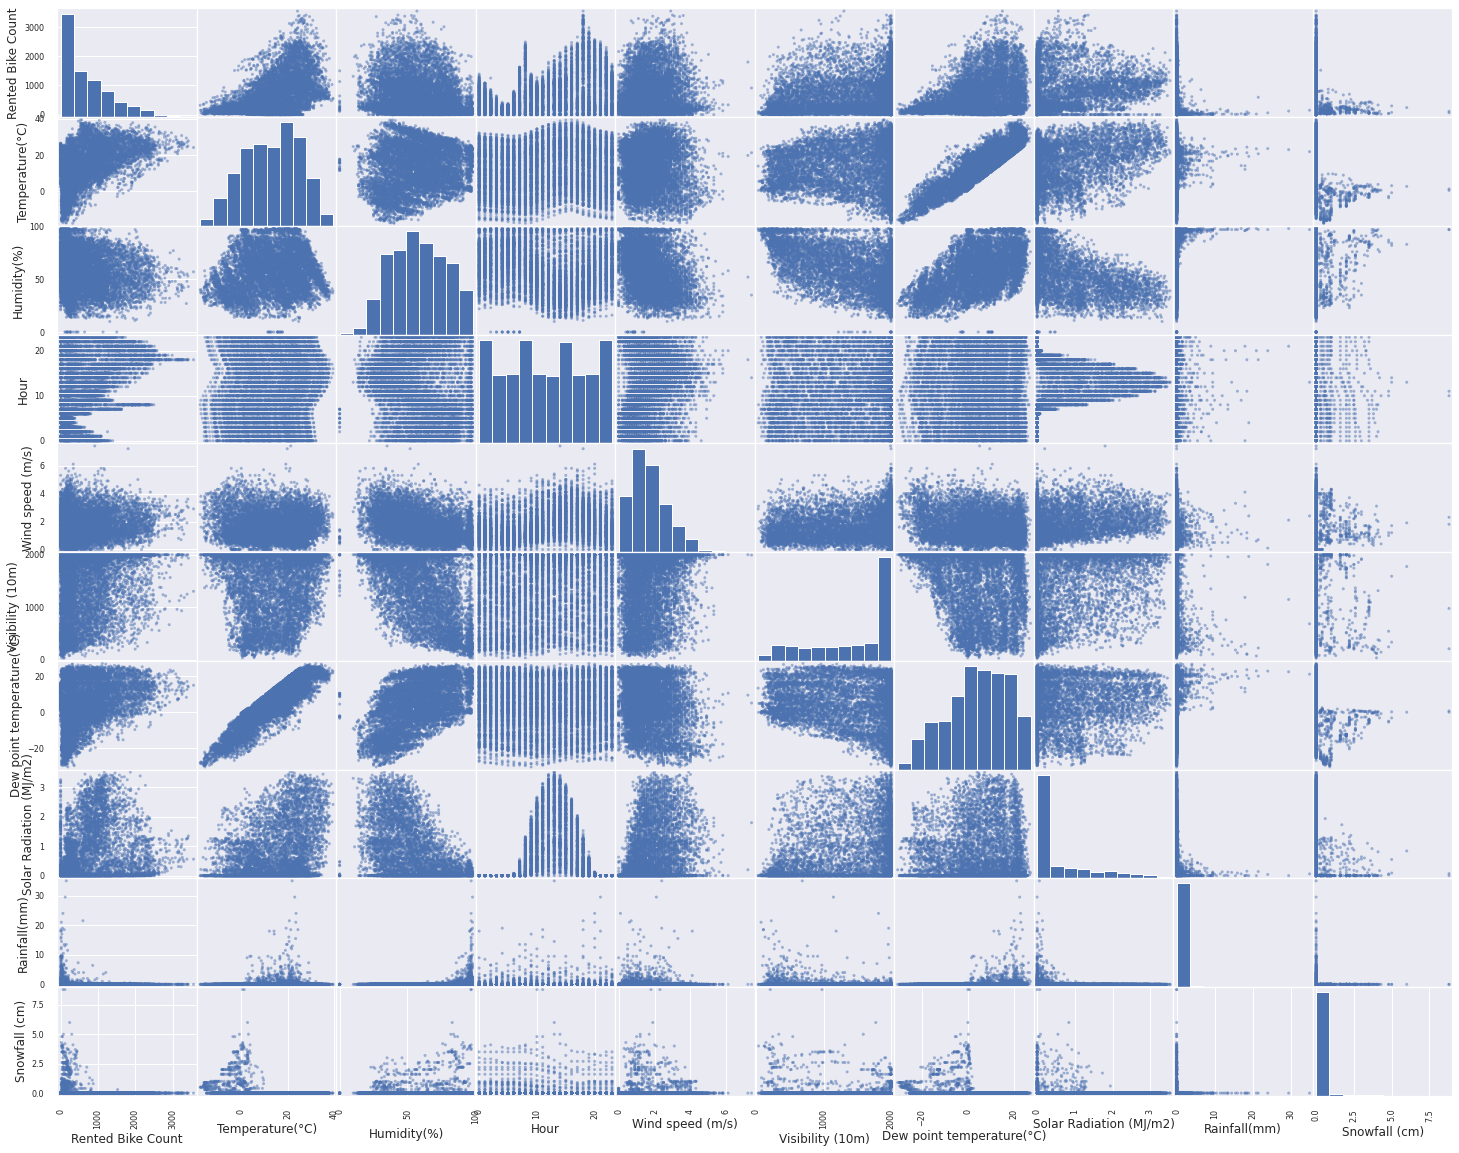

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Hour',
     'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

scatter_matrix(dtWitOut[attributes], figsize=(25, 20))

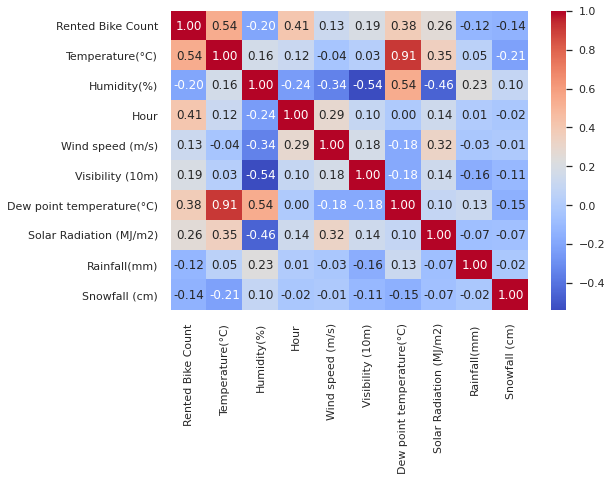

In [ ]:
sns.heatmap(dtWitOut[
  ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Hour',
   'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
   'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
  ].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

High relation between Rented Bike Count and Temperature.
Low relation of Rainfall and Snowfall with other attributes.


### Bicycles rented by the hour 

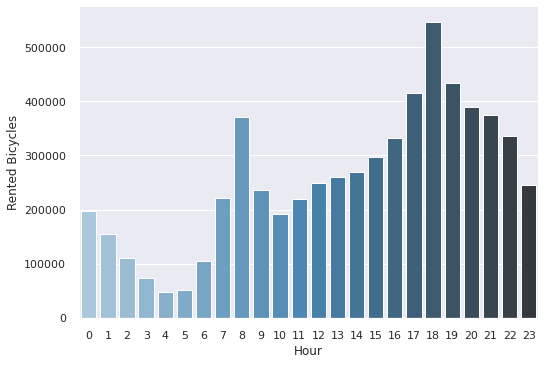

In [ ]:
hour = pd.DataFrame({'Hour': [i for i in range(24)], 
                     'Rented Bicycles': dtWitOut.groupby('Hour').sum()['Rented Bike Count']})

sns.catplot(x='Hour', y='Rented Bicycles', kind='bar', data=hour, height=5, aspect=1.5, 
    palette='Blues_d', ci=None)

### Bicycles rented by season

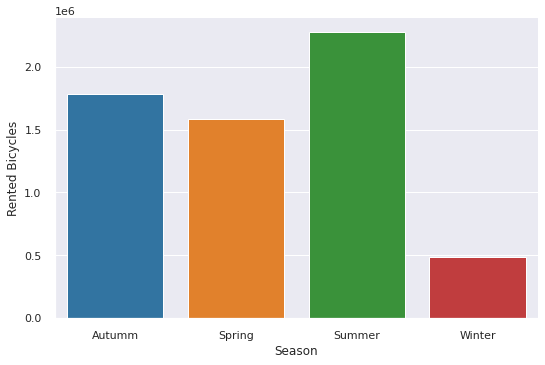

In [ ]:
labels = ['Autumm', 'Spring', 'Summer', 'Winter']
season = pd.DataFrame({'Season': labels, 
                       'Rented Bicycles': dtWitOut.groupby('Seasons').sum()['Rented Bike Count']})

sns.catplot(x='Season', y='Rented Bicycles', kind='bar', data=season, height=5, 
            aspect=1.5, ci=None, palette=sns.color_palette("tab10"))

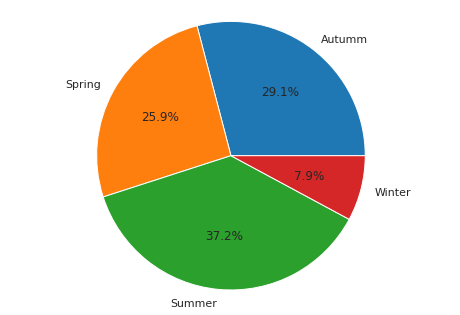

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(dtWitOut.groupby('Seasons').sum()['Rented Bike Count'], 
        labels=labels, autopct='%1.1f%%', colors=sns.color_palette("tab10"))
ax1.axis('equal')
plt.show()

## Data pre-processing

In [ ]:
X = dtWitOut.iloc[:, 2:].values
y = dtWitOut.iloc[:, 1].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Converts stations
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [9])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
# Convert holidays
le = LabelEncoder()
X[:, 13] = le.fit_transform(X[:, 13])

In [ ]:
# Converts working days
X[:, 14] = le.fit_transform(X[:, 14])

## Division of the dataset in training and testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Scaling of dependent variables

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train[:, 4:-2] = ss.fit_transform(X_train[:, 4:-2])
X_test[:, 4:-2] = ss.fit_transform(X_test[:, 4:-2])

## Training (Random Forest Regression)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'n_estimators': [3, 10, 30, 60], 'max_features': [8, 10, 12, 14]},
  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [6, 8, 10]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 60}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

12.921542404489914 {'max_features': 8, 'n_estimators': 3}
12.271068429592798 {'max_features': 8, 'n_estimators': 10}
12.000696326829004 {'max_features': 8, 'n_estimators': 30}
11.939412758789842 {'max_features': 8, 'n_estimators': 60}
12.939503925425313 {'max_features': 10, 'n_estimators': 3}
12.218248434572779 {'max_features': 10, 'n_estimators': 10}
12.00647806399035 {'max_features': 10, 'n_estimators': 30}
11.91005464245052 {'max_features': 10, 'n_estimators': 60}
12.865251026318898 {'max_features': 12, 'n_estimators': 3}
12.133874716893922 {'max_features': 12, 'n_estimators': 10}
11.957493610648104 {'max_features': 12, 'n_estimators': 30}
11.950899608061356 {'max_features': 12, 'n_estimators': 60}
12.885777385629924 {'max_features': 14, 'n_estimators': 3}
12.188392601295567 {'max_features': 14, 'n_estimators': 10}
11.994454378283846 {'max_features': 14, 'n_estimators': 30}
11.965176580929906 {'max_features': 14, 'n_estimators': 60}
12.812257934360835 {'bootstrap': False, 'max_featu

## Prediction of test data

In [ ]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
np.set_printoptions(precision=3)

## Comparing the prediction with the actual values

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[1070.083 1197.   ]
 [1128.333  917.   ]
 [1015.067 1020.   ]
 ...
 [ 168.367  159.   ]
 [ 404.533  788.   ]
 [ 450.8    450.   ]]


## Performance indicator 

### Mean Absolute Error

In [ ]:
from sklearn.metrics import mean_absolute_error

forest_mae = mean_absolute_error(y_test, y_pred)
print(forest_mae)

145.02210688196848


Big different between MAE of training and of test. Probable cause is overfitting. Forms of correction: (a) simplify the model or (b) add more data.


Observation: after remove of columns Rainfall and Snowfall the model presented slightly worse of performance.

### Mean Squared Error

In [ ]:
from sklearn.metrics import mean_squared_error

forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

233.59445179648142


## Performing prediction

**Input values:**

1. Season: Autumn
1. Time: 7:00
1. Temperature (° C): 5
1. Humidity (%): 20
1. Wind speed (m / s): 0.3
1. Visibility (m): 1900
1. Dew point temperature (° C): -5
1. Solar radiation (MJ / m2): 0.2
1. Rain (mm): 0
1. Snowfall (cm): 0
1. Holiday: No
1. Business day: Yes

**Prediction:** 1141 bikes


In [67]:
a = [1,0,0,0]
b = [7,5,20,0.3,1900,-5,0.2,0,0]
c = [1,1]
aux = ss.transform([b])
pred = np.concatenate([a, aux[0], c])
print(final_model.predict([pred]))

[1141.3]
